In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [79]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime

import torch
import torch.nn as nn

Read Data


In [80]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

Not Disaster tweets

In [81]:
train_df[train_df.target==0]['text']

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [82]:
train_df[train_df.target==1]['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

Check if the data is balanced

In [83]:
train_df["target"].value_counts() / len(train_df) *100

target
0    57.034021
1    42.965979
Name: count, dtype: float64

Text(0, 0.5, 'count')

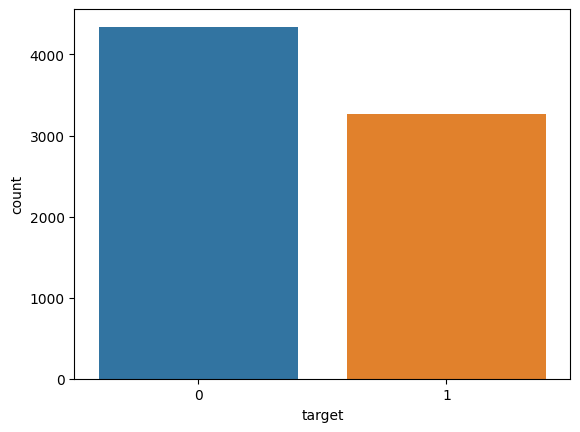

In [84]:
ax = sns.countplot(x='target', data=train_df)
ax.set_xlabel('target')
ax.set_ylabel("count") 

Word cloud for disaster tweets

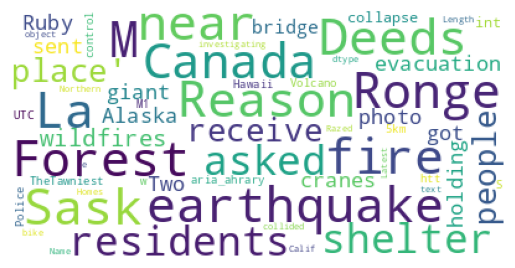

In [85]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train_df[train_df.target==1]['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=300)

Word cloud of non disaster tweet

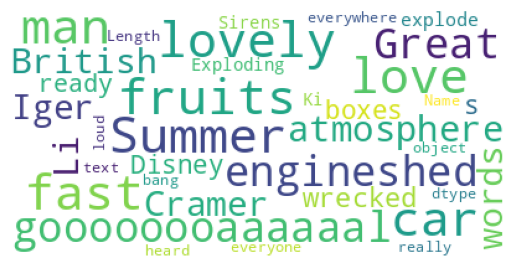

In [86]:
stopwords = set(STOPWORDS)


wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train_df[train_df.target==0]['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

Split training and testing set

In [87]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], test_size=0.1, random_state=42 )

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_train.head(3))

(6851,)
(6851,)
(762,)
(762,)
4620    'McFadden Reportedly to Test Hamstring Thursda...
2858    w--=-=-=-[ NEMA warns Nigerians to prepare for...
3098    When I was cooking earlier I got electrocuted ...
Name: text, dtype: object


In [88]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.tokenizer

Data Cleaning

In [89]:
def normalise_text(text):
    text = text.str.lower()
    
    replace_pairs = [
        [r"\#",""],
        [r"http\S+","URL"], 
        [r"@",""],
        [r"[^A-Za-z0-9()!?\'\`\"]", " "],
        ["\s{2,}", " "]
    ]

    for pair in replace_pairs:               
        text = text.str.replace(pair[0], pair[1])
                     
    return text

In [90]:
X_train = normalise_text(X_train)
print(X_train.head(3))

X_val = normalise_text(X_val)
print(X_val.head(3))

4620    'mcfadden reportedly to test hamstring thursda...
2858    w--=-=-=-[ nema warns nigerians to prepare for...
3098    when i was cooking earlier i got electrocuted ...
Name: text, dtype: object
2644    so you have a new weapon that can cause un-ima...
2227    the f$&amp;ing things i do for #gishwhes just ...
5448    dt georgegalloway: rt galloway4mayor: ûïthe c...
Name: text, dtype: object


In [91]:
idx = 1
word2idx = {'<PAD>': 0}

for row in X_train:
    tokens = row.lower().split()
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [92]:
print(len(word2idx))

25826


In [93]:
train_sentences_as_int = []
for row in X_train:
    tokens = row.lower().split()
    sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
    train_sentences_as_int.append(sentence_as_int)
    
print(len(train_sentences_as_int))
print(train_sentences_as_int[0])

6851
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [94]:
val_sentences_as_int = []
for row in X_val:
    tokens = row.lower().split()
    sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
    val_sentences_as_int.append(sentence_as_int)
    
print(len(val_sentences_as_int))
print(val_sentences_as_int[0])

762
[1064, 102, 128, 65, 1002, 239, 77, 256, 305, 13367]


In [95]:
def data_generator(X, y, batch_size = 32):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    for i in range(n_batches):
        end = min((i + 1) * batch_size, len(y))
        
        X_batch = X[i * batch_size:end]
        y_batch = y[i * batch_size:end]
        
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [0] * (max_len - len(x))
            X_batch[j] = pad + x
            
        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()
        
        yield X_batch, y_batch

In [96]:
for inputs, targets in data_generator(train_sentences_as_int, y_train):
    print(f"Inputs: {inputs}, shape: {inputs.shape}")
    print(f"Targets: {targets}, shape: {targets.shape}")
    break

Inputs: tensor([[    0,     0,     0,     0,     0,     0,     0,     0,    41,  4229,
          1631,  8573,  4075,  8574,   214,    41,  8575,  1158,  2800,   701,
          4456,    77,  1161,  1025,  8576],
        [    0, 16716, 16717, 16718,  7320,  1557,  1064, 10189,    56,   103,
          2916,   782,  2544,  1557,  7639, 16719,  1120,   101,  1351, 16720,
         16721,  5385,    40,    65,  2975],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            87,  1072,  7319,  1756,  1218,  7320,   405,  7321,    40,  2914,
          7322,  7323,  7324,  7325,  7326],
        [    0,     0,     0,     0,     0,   491,  1852,  4959,  1357,  4960,
          4961,   109,    65,   938,  4962,    63,  1357,   252,     3,   260,
          4963,   142,  2065,   205,  4964],
        [    0,     0,     0,  2012,  2441,  2442,    77,   214,  2443,  2444,
          2441,  2445,  2446,  1720,   415,    47,    41,  2447,  2448,  2054,
          2449,    47,

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


RNN Model

In [98]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
            )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        out = self.embed(X)
        
        out, _ = self.rnn(out, (h0, c0))
        
        out, _ = torch.max(out, 1)
        
        out = self.fc(out)
        return out

In [99]:
model = RNN(len(word2idx), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(25826, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [100]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [101]:
train_gen = lambda: data_generator(train_sentences_as_int, y_train)
val_gen = lambda: data_generator(val_sentences_as_int, y_val)

In [102]:
def batch_gd(model, critetion, optimizer, epochs):
    train_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)
        
        train_losses.append(train_loss)
             
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}')
    
    return train_losses
            

In [103]:
train_losses = batch_gd(model, criterion, optimizer, 15)

Epoch 1/15, Train Loss: 0.6815, Duration: 0:00:01.400241
Epoch 2/15, Train Loss: 0.6507, Duration: 0:00:01.297250
Epoch 3/15, Train Loss: 0.5647, Duration: 0:00:01.295979
Epoch 4/15, Train Loss: 0.4911, Duration: 0:00:01.301986
Epoch 5/15, Train Loss: 0.4282, Duration: 0:00:01.300383
Epoch 6/15, Train Loss: 0.3755, Duration: 0:00:01.266070
Epoch 7/15, Train Loss: 0.3303, Duration: 0:00:01.265917
Epoch 8/15, Train Loss: 0.2896, Duration: 0:00:01.259596
Epoch 9/15, Train Loss: 0.2562, Duration: 0:00:01.267350
Epoch 10/15, Train Loss: 0.2254, Duration: 0:00:01.255380
Epoch 11/15, Train Loss: 0.1982, Duration: 0:00:01.233389
Epoch 12/15, Train Loss: 0.1741, Duration: 0:00:01.269896
Epoch 13/15, Train Loss: 0.1539, Duration: 0:00:01.293958
Epoch 14/15, Train Loss: 0.1355, Duration: 0:00:01.289210
Epoch 15/15, Train Loss: 0.1209, Duration: 0:00:01.256707


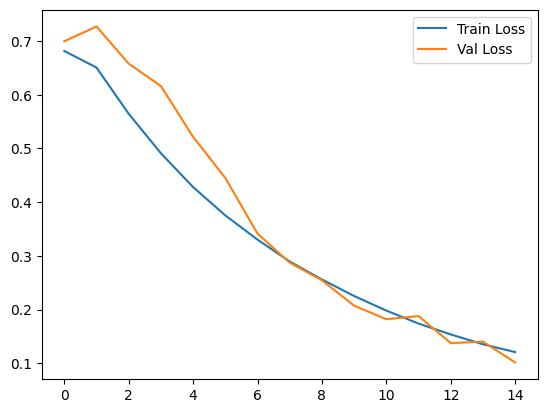

In [104]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

In [105]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in val_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Val acc: {test_acc:.4f}")

Train acc: 0.9673, Val acc: 0.7428


Hypertuning first try - increase number of epoch from 15 to 30

In [106]:
def batch_gd(model, critetion, optimizer, epochs):
    train_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)
        
        train_losses.append(train_loss)
             
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}')
    
    return train_losses

In [112]:
train_losses = batch_gd(model, criterion, optimizer, 30)

Epoch 1/30, Train Loss: 0.0085, Duration: 0:00:01.347144
Epoch 2/30, Train Loss: 0.0086, Duration: 0:00:01.323516
Epoch 3/30, Train Loss: 0.0082, Duration: 0:00:01.288029
Epoch 4/30, Train Loss: 0.0082, Duration: 0:00:01.296289
Epoch 5/30, Train Loss: 0.0083, Duration: 0:00:01.300382
Epoch 6/30, Train Loss: 0.0080, Duration: 0:00:01.314250
Epoch 7/30, Train Loss: 0.0080, Duration: 0:00:01.311626
Epoch 8/30, Train Loss: 0.0080, Duration: 0:00:01.324302
Epoch 9/30, Train Loss: 0.0082, Duration: 0:00:01.369702
Epoch 10/30, Train Loss: 0.0078, Duration: 0:00:01.323589
Epoch 11/30, Train Loss: 0.0078, Duration: 0:00:01.271238
Epoch 12/30, Train Loss: 0.0075, Duration: 0:00:01.315278
Epoch 13/30, Train Loss: 0.0080, Duration: 0:00:01.334825
Epoch 14/30, Train Loss: 0.0073, Duration: 0:00:01.364308
Epoch 15/30, Train Loss: 0.0077, Duration: 0:00:01.261803
Epoch 16/30, Train Loss: 0.0076, Duration: 0:00:01.266001
Epoch 17/30, Train Loss: 0.0077, Duration: 0:00:01.358756
Epoch 18/30, Train Loss

In [113]:
# Updated Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in val_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Val acc: {test_acc:.4f}")

Train acc: 0.9969, Val acc: 0.7310


When the number of epoch increased, the validation accuaracy goes down from 0.7428 to 0.7310 -> this indicates an overfit. 
Train for more epochs, but stop when val performance stops improving. 

Hypertuning second try - Reduce number of epochs and change model architecture

In [120]:
model = RNN(len(word2idx), 200, 256, 2, 1).to(device)
model.to(device)

RNN(
  (embed): Embedding(25826, 200)
  (rnn): LSTM(200, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [121]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [122]:
train_gen = lambda: data_generator(train_sentences_as_int, y_train)
val_gen = lambda: data_generator(val_sentences_as_int, y_val)

In [123]:
def batch_gd(model, critetion, optimizer, epochs):
    train_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)
        
        train_losses.append(train_loss)
             
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}')
    
    return train_losses

In [127]:
train_losses = batch_gd(model, criterion, optimizer, 8)

Epoch 1/8, Train Loss: 0.0072, Duration: 0:00:15.802978
Epoch 2/8, Train Loss: 0.0069, Duration: 0:00:15.814418
Epoch 3/8, Train Loss: 0.0070, Duration: 0:00:15.733467
Epoch 4/8, Train Loss: 0.0065, Duration: 0:00:15.802252
Epoch 5/8, Train Loss: 0.0068, Duration: 0:00:23.459774
Epoch 6/8, Train Loss: 0.0063, Duration: 0:00:23.338137
Epoch 7/8, Train Loss: 0.0064, Duration: 0:00:23.360772
Epoch 8/8, Train Loss: 0.0525, Duration: 0:00:23.339699


In [128]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in val_gen():
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = (outputs > 0)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Val acc: {test_acc:.4f}")

Train acc: 0.9915, Val acc: 0.7520


Now the validation accuracy increased from 0.7428 to 0.7520. The change is minor, but the LSTM classifier still shows clear signs of improvement.
Reducing the number of training epochs from 15 to 8 helped prevent overfitting, while increasing the model capacity by using a larger embedding dimension (200), a larger hidden state (256), and deeper recurrent structure (2 LSTM layers) improved the model’s ability to capture richer semantic patterns in the text.

Overall, the new configuration strikes a better balance between model complexity and overfitting. The improvement in validation accuracy, despite having fewer epochs, confirms that model architecture changes were more beneficial than simply training longer.

Further gains would likely require improvements in preprocessing (e.g., better tokenization), regularization techniques (dropout, weight decay), or transitioning to more advanced architectures such as pretrained transformers.